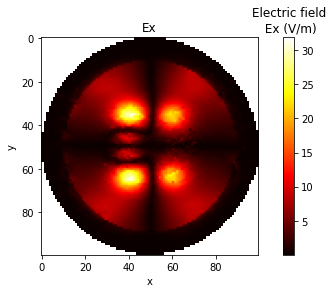

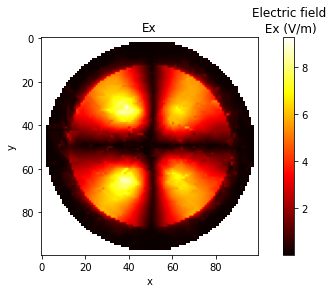

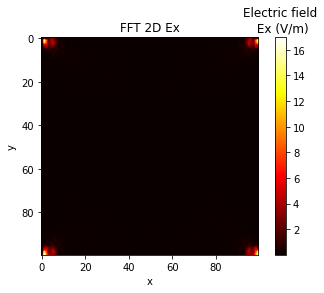

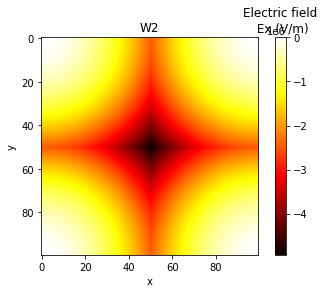

C:\Users\aitor\AppData\Local\Temp\ipykernel_16640\605942650.py:163: ComplexWarning: Casting complex values to real discards the imaginary part
  w2[valoresNegativos] = -1j*np.sqrt(-1*w2[valoresNegativos])


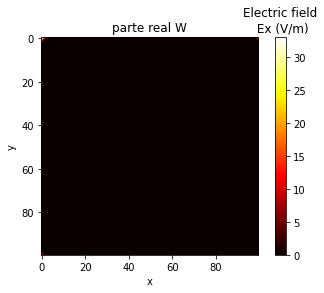

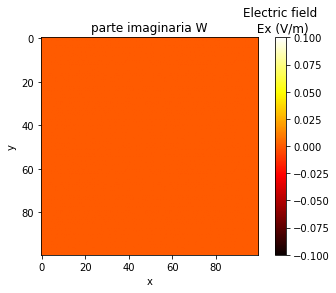

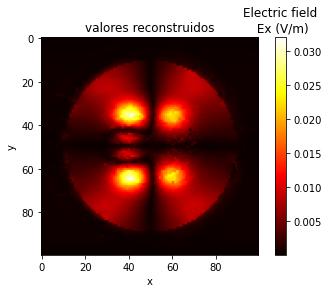

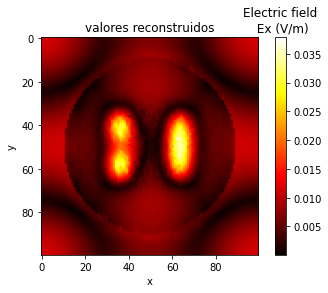

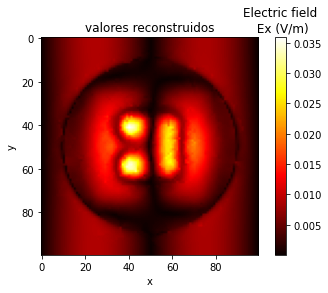

FIN PROGRAMA


In [11]:
__author__ = "joseluis"

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

#VARIABLES GLOBALES
mu0           = 4*np.pi*1e-7
c0            = 299792458
raw_data      = 9
pauseinterval = 0.01
k0 ,delta_x,L_x,delta_y,L_y,coordz = 0,0,0,0,0,0
flow_config = { 'directory':r'c:\\Users\\aitor\\OneDrive\\Desktop\\TFG-AitorIngelmo\\Codigos\\NF to NF\\codigo JL',
                'files_in_directory': [
                    'microstrip_patch_antenna_Ex.txt',
                    'microstrip_patch_antenna_Ey.txt',
                    'microstrip_patch_antenna_Ez.txt',
                    'microstrip_patch_antenna_normE.txt'                
                ],
                'file_type':['Ex','Ey','Ez','normE'],
                'work_mode':'NFtoFF',      
                'shape':[100,100,100],
                'freq':1.575e9,
                'length_unit':1e-3,
                'res':2e-3}

def inputDataProcess(flow_config):
    # Este es el constructor de la clase. En él almacenamos los inputs como atributos de la clase.
    global k0
    try:
        fields,files,datavalues,lines,zValueplane,zValueMaskedplane,zValueZeroedplane = {}, {}, {}, {}, {} , {}, {}     
        if len(flow_config['file_type']) == len(flow_config['files_in_directory']):
            for file_type in range(len(flow_config['file_type'])):
                files.update({flow_config['file_type'][file_type]:f"{flow_config['directory']}//{flow_config['files_in_directory'][file_type]}"})
        else:
            raise Exception("El número de ficheros en el directorio es distinto a la cantidad de ficheros introducido")
        fields.update({'files':files})
        fields.update({'file_type':flow_config['file_type']})
        fields.update({"datavalues":datavalues})
        fields.update({"lines":lines})
        fields.update({"zValueplane":zValueplane}) 
        fields.update({"zValueMaskedplane":zValueMaskedplane}) 
        fields.update({"zValueZeroedplane":zValueZeroedplane})
        fields.update({'fields_transformed':{}})
        fields.update({'quantitative_comparison':{}})          
        fields.update({'shape':flow_config['shape']})
        fields.update({'freq':flow_config['freq']})    
        fields.update({'length_unit':flow_config['length_unit']})
        fields.update({'res':flow_config['res']})
        k0 = 2*np.pi*flow_config['freq']/c0
    except Exception as exc:
        print(f"ERROR:{exc}")

    return fields
def readData(fields,read_type='all'):
    """
    Este método realiza la lectura de todos o parte de los ficheros de salida de Comsol 
    para las componentes del campo eléctrico.
        "fields": Es el diccionario principal sobre el que estamos trabajando
        "read_type": Es una variable opcional empleada para definir el modo de lectura.
                        Por defecto lee todos los ficheros. Pero podemos especificarle que
                        lea algunos en concreto si la igualamos a un diccionario que contenga 
                        los ficheros a leer.                  
    """
    if read_type == 'all':
        for file_type, file_path in fields['files'].items():
            with open(file_path) as file:
                fields['lines'][file_type] = file.readlines()
    #TODO: Que lea los ficheros dentro de read_type en caso de no tener el valor por defecto
     
def extractMatrixData(fields):
    """
    Este método almacena en arrays los datos de los ficheros de Comsol leídos previamente con readData             
    """
    global delta_x,L_x,delta_y,L_y,coordz
    #filetypes = lines.keys()
    coord_flag = None
    for file_type in fields['lines'].keys(): #file_type
        datatype     = file_type
        rawdatalines = fields['lines'][file_type][raw_data:]
        if coord_flag == None:
            coord_flag = 1
            coord      = np.array([[float(s) for k,s in zip(range(4),rawdatalines[i].split()) if k<3 ] \
                for i in range(len(rawdatalines))]).reshape(len(rawdatalines),3)
            
            coordx  = np.unique(coord[:,0])*fields['length_unit']
            delta_x = coordx[1]-coordx[0]
            L_x     = coordx[-1]-coordx[0]
            coordy  = np.unique(coord[:,1])*fields['length_unit']
            delta_y = coordy[1]-coordy[0]
            L_y     = coordy[-1]-coordy[0]
            coordz  = np.unique(coord[:,2])*fields['length_unit']
          
        fields['datavalues'][datatype] = np.array([complex(s.replace('i', 'j')) for i in range(len(rawdatalines)) \
            for k,s in zip(range(4),rawdatalines[i].split()) if k == 3])
        
def extractZvalueCut(fields,field_components,cuts_to_extract):
    """
    Este método nos permite extraer los valores del campo en un cierto número de cortes o valores de z 
        "fields": Es el diccionario que contiene los datos que estamos tratando en el programa.
        "field_components":Es el array que contiene todas las componentes que sobre las cuales 
                           queremos extraer los cortes.
        "cuts_to_extract" : Es el array que contiene los cortes (medidos en metros) que deseamos extraer.       
    """    
    numberOfCuts = len(cuts_to_extract)
    shape_0      = fields['shape'][0]
    shape_1      = fields['shape'][1]

    if numberOfCuts == 1:
        indexarray = list(np.where(np.abs(coordz-cuts_to_extract)<fields['res'])[0])
    else:
        indexarray = [np.where(np.abs(coordz-cuts_to_extract[i])<fields['res'])[0][0] for i in range(numberOfCuts)]
    position0 = np.array([shape_0*shape_1*indexarray[i] for i in range(numberOfCuts)])
    indices   = [range(position0[i],position0[i]+shape_0*shape_1) for i in range(numberOfCuts)]
    
    for field_component in field_components:
        field_component_value = fields['datavalues'][field_component]
        fields['zValueplane'][field_component] = np.array([field_component_value[indices[i]] for i in range(numberOfCuts)]).reshape(numberOfCuts,shape_0,shape_1)

def maskvalueCut(fields,datatypes):
    for datatype in datatypes:
        fields['zValueMaskedplane'][datatype] = ma.masked_invalid(fields['zValueplane'][datatype])

def zeroedvalueCut(fields,datatypes):
    for datatype in datatypes:
        indices = np.isnan(fields['zValueplane'][datatype])
        fields['zValueZeroedplane'][datatype] = np.copy(fields['zValueplane'][datatype])
        fields['zValueZeroedplane'][datatype][indices] = 0.0

def plotZvalueCut(plotnumber,value_to_plot,plotinfo,datatype,cutNumber,func=lambda x:x,aspect='equal',extent=None,colorbar=True,cmap='binary'):
    plt.figure(plotnumber)
    im = plt.imshow(func(value_to_plot[datatype][cutNumber]).transpose(),cmap=cmap,aspect=aspect,extent=extent)
    plt.xlabel(plotinfo['xlabel'])
    plt.ylabel(plotinfo['ylabel'])
    plt.title(plotinfo['title'])
    if colorbar == True:
        cbar = plt.colorbar(pad=0.075)
        cbar.ax.set_title(plotinfo['legend'])
    plt.draw()
    plt.pause(pauseinterval)

def nearfieldPoint0toPoint1(fields,cut):
    zeroedvalueCut(fields,fields['file_type'])
    Nx = fields['zValueZeroedplane']['Ex'][cut].shape[0]
    Ny = fields['zValueZeroedplane']['Ex'][cut].shape[1]

    delta_kx = 2*np.pi/(delta_x*Nx)
    delta_ky = 2*np.pi/(delta_y*Ny)
    factorf  = L_x*L_y*Nx*Ny/(4*np.pi**2*(Nx-1)*(Ny-1))       
    dimension = fields['shape'][0]

    kxcoordinatesMatrix=np.ones((dimension,dimension))
    for j in range(dimension):  
        for i in range(dimension):            
            if i<=(dimension/2):
                indice=i-1
            else:
                indice=i-1-dimension
            kxcoordinatesMatrix[i-1][j-1]=(delta_kx*indice)
    kycoordinatesMatrix = np.rot90(kxcoordinatesMatrix,1)
   
    w2 = k0**2 - kxcoordinatesMatrix**2 - kycoordinatesMatrix**2
    representarValores(4,'W2',w2)

    valoresPositivos = np.where(w2 >= 0)
    valoresNegativos = np.where(w2 < 0)
    w2[valoresPositivos] = np.sqrt(w2[valoresPositivos])
    w2[valoresNegativos] = -1j*np.sqrt(-1*w2[valoresNegativos])
    w = np.conjugate(w2)

    #PLOTS de W
    representarValores(5,'parte real W',np.real(w))      
    representarValores(6,'parte imaginaria W',np.imag(w))

    phaseShift = np.exp(-j*w*(31.e-3 - 15.e-3))  

    fields_to_transform = list(fields['zValueZeroedplane'].keys())
    for i in range(len(fields['zValueZeroedplane'].keys())):
        Ehat_component_calculated = factorf*np.fft.fft2((fields['zValueZeroedplane'][fields_to_transform[i]][cut]))
        representarValores(3,f'FFT 2D de {fields_to_transform[i]}',np.abs(Ehat_component_calculated))

        fields['fields_transformed'].update({f"NF_{fields_to_transform[i]}":Ehat_component_calculated})

        EhatEnZ1 = Ehat_component_calculated*phaseShift
        EhatxReconstruido = np.fft.ifft2(EhatEnZ1)
        representarValores(3,f'FFT 2D de {fields_to_transform[i]} en FF',np.abs(EhatxReconstruido).transpose())

        """
        comparison = quantitativeComparison(fields['zValueZeroedplane'][fields_to_transform[i]][1],EhatxReconstruido)
        plt.plot(comparison)
        plt.show()
        fields['quantitative_comparison'].update({f"{fields_to_transform[i]}_comparison":comparison})        
        """

def representarValores(plot_number, title, values_to_plot,leyenda = 'Electric field\n Ex (V/m)',mapaDeColores = 'hot'):
        
    plt.figure(plot_number)
    im = plt.imshow(values_to_plot,cmap=mapaDeColores,aspect='equal',extent=None)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.ax.set_title(leyenda)
    plt.draw()
    plt.pause(pauseinterval)

def quantitativeComparison(comsol_simulated_value,value_calculated_value):    
    

    comsol_simulated_value = np.where(np.abs(comsol_simulated_value) > 0, comsol_simulated_value, 0.0000001)
    comparison = np.abs(comsol_simulated_value - value_calculated_value) / np.abs(comsol_simulated_value)
        
    comparison_without_zeros = np.copy(comparison[np.nonzero(comparison)])
    return comparison

if __name__ == '__main__':
    plt.close('all')
    #try:

    fields = inputDataProcess(flow_config)
    
    readData(fields)        
    
    extractMatrixData(fields)   

    extractZvalueCut(fields,fields['file_type'],cuts_to_extract = [15.e-3,31.e-3])
    
    #Este método quita de en medio los NaN.
    maskvalueCut(fields,fields['file_type'])

    #En estas líneas se hacen las representaciones de los cortes.
    plotinfo = {'xlabel':'x','ylabel':'y','title':'Ex','legend':'Electric field\n Ex (V/m)'}
    plotZvalueCut(1,fields['zValueMaskedplane'],plotinfo,'Ex',0,func=np.abs,cmap='hot')
    plotZvalueCut(2,fields['zValueMaskedplane'],plotinfo,'Ex',1,func=np.abs,cmap='hot')
    
    #fields.pop('lines')
    #print(fields)
    
    #fields.zeroedvalueCut(['Ex','Ey','Ez','normE'])
    nearfieldPoint0toPoint1(fields,cut = 0)                
    print("FIN PROGRAMA")
    #     
    #except Exception as exc:
        #print(exc)

